## Introduction:

This notebook is devoted to implement Q learning algorithm on Left_Right problem .. a case study in Batch Learning paper (Page 14) .. 

Paper Link ==> http://www.jmlr.org/papers/v6/ernst05a.html

Guided by this tutorial ==> http://mnemstudio.org/path-finding-q-learning-tutorial.htm

and also this one ==> https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0


## Experimental Setup:

num of simulations = 100,000

s = rand(0, 10)     selected at random 

a = [-2, 2] ==> -2: left, 2: right

r = [100, 0, 50] ==> 0: inside the interval, 50: left, 100: right

num of episods = 300 

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import linear_model
import tensorflow as tf
import pandas as pd
%matplotlib inline

## Variables Decleration: 

__Episods:

We'll call each exploration an episode.  
Each episode consists of the agent moving from the initial state to the goal state.  
Each time the agent arrives at the goal state, the program goes to the next episode.
hence, the episod is treated as if it's the number of runs! (Each episode is equivalent to one training session)


In [2]:
## num episods
num_episod = 300

# ## num_experiments
# num_exp = 100000

gamma = 0.9 
alpha = 0.3

## input Tuple
state = np.random.randint(0, 0 + 11 , size=10) # create array from 1 to 10 randomly 
s_next = np.random.randint(0, 0 + 11 , size=10) # create array from 1 to 10 randomly 
action = np.random.choice([0, 1], state.shape[0]) # to be able to access Q indices .. left = 0, right = 1 instead of -2, 2

Curr_state_current_action = np.column_stack((state, action))

reward = [np.random.choice([50], state.shape[0]), np.random.choice([100], state.shape[0])]  # reward is a matrix
reward = np.transpose(reward)

## Q_table
Q = np.zeros(np.shape(reward))
reward

array([[ 50, 100],
       [ 50, 100],
       [ 50, 100],
       [ 50, 100],
       [ 50, 100],
       [ 50, 100],
       [ 50, 100],
       [ 50, 100],
       [ 50, 100],
       [ 50, 100]])

## ___________________ 1. Basic Q Model  ___________________

In [3]:
for i in range(num_episod):
    current_state = np.random.choice(state) #select random state 
    if current_state == 10:
        break
    else:
        current_state = np.random.choice(action)
        next_state = np.random.choice(s_next) #consider moving to the next state

        Q[current_state, action] = reward[current_state, action] + gamma*np.max(Q[next_state, :])
        current_state = next_state

print Q

[[  50.  100.]
 [  50.  100.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   0.    0.]]


## Avg. Q and plotting it: 

To be able to compare the performance in every set of episods .. 
let's calculate the mean over the total of 300 episods !

In [4]:
np.mean(Q)

15.0

Let's plot the Q value over each state and its corresponding action .. 

every color represents different possible action 

Text(0,0.5,u'Q Value')

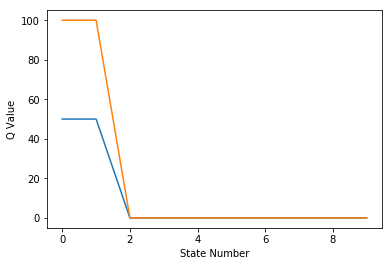

In [5]:
plt.plot(Q)
plt.xlabel("State Number")
plt.ylabel("Q Value")

## Comment:
the above graph is different from those plotted in the batch paper .. cause they represent the result of applying tree pruning algorithm called (Pruned CART Tree) ... read more about ==> https://www.quora.com/Decision-Trees-How-do-you-prune-a-CART

## ___________________ 2. Linear Regression Implementation ___________________

In [6]:
## Q_table
output = np.zeros([10, 1]) #np.zeros(np.shape(reward[:,1]))
s1_a1 = np.column_stack((s_next, np.zeros_like(action)))
s2_a2 = np.column_stack((s_next, np.ones_like(action)))

reward_LR = np.random.choice([50, 100], state.shape[0])
reward_LR

array([ 50, 100,  50, 100, 100,  50,  50, 100,  50, 100])

In [7]:
def regression(Curr_state_current_action, output): #states w el rewards
    regr = linear_model.LinearRegression()
    regr.fit(Curr_state_current_action, output)
    predicted_Q_1 = regr.predict(s1_a1)
    predicted_Q_2 = regr.predict(s2_a2)
    predicted_Q = [predicted_Q_1,predicted_Q_2]
    
    return np.transpose(predicted_Q)

In [24]:
for i in range(num_episod):
#     current_action = np.random.choice(action)
#     next_state = np.random.choice(s_next) #consider moving to the next state
    output = reward_LR + gamma*np.amax(Q, axis = 1)  # returns max value per row !
    Q = regression(Curr_state_current_action, output)
print output

[  982.86655684  1037.80889621   977.92421746  1018.03953871  1037.80889621
   977.92421746   977.92421746  1042.75123558   953.21252059  1042.75123558]


## Avg. Q and plotting it: 

To be able to compare the performance in every set of episods .. 
let's calculate the mean over the total of 300 episods !

In [25]:
np.mean(output)

1004.9011532125203

Let's plot the Q value over each state and its corresponding action .. 

every color represents different possible action 

Text(0,0.5,u'Q Value')

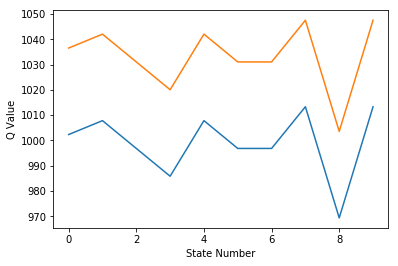

In [26]:
plt.plot(Q)
plt.xlabel("State Number")
plt.ylabel("Q Value")

## Comment:

Long term rewards of left, right actions given the current state is getting higher and the gap that distinguish those actions is getting higher .. 

Linear regression performs better than tableauer form .. 

## 3. ANN:

In [32]:
batch_size = 5
n_nodes_hl1 = 40
n_nodes_hl2 = 15
NUM_STATES = np.shape(Q)[0]
NUM_ACTIONS = np.shape(Q)[1]

In [33]:
## init weights .. 

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=1))

In [34]:
def model(X, w_h, w_o,bias_I,bias_h):
    h = tf.nn.relu(tf.matmul(X, w_h)+bias_I) 
    py_x = tf.matmul(h, w_o) + bias_h
    return py_x # note that we dont take the softmax at the end because our cost fn does that for us

In [38]:
def model_training(Curr_state_current_action, output):

    Curr_state_current_action = Curr_state_current_action.astype(np.float32) 
    w_h = init_weights([5, n_nodes_hl1]) # create symbolic variables\n",
    w_o = init_weights([n_nodes_hl1, 1])
    bias_I=init_weights([n_nodes_hl1])

    bias_h=init_weights([1])
    py_x = model(Curr_state_current_action, w_h, w_o,bias_I,bias_h)  #model training  

    cost = tf.reduce_mean(tf.square(py_x - output)) # compute costs\n",

    train_op = tf.train.GradientDescentOptimizer(0.05).minimize(cost) # construct an optimizer\n",
    
    sess = tf.Session()
    init = tf.initialize_all_variables()
    sess.run(init)
    
    
    return w_h, w_o,bias_I,bias_h        

In [39]:
## Prediction phase: 
def model_predict(s1_a1, s2_a2, output):

    s1_a1 = s1_a1.astype(np.float32)
    [w_h, w_o,bias_I,bias_h] = model_training(s1_a1, output)
    predict_op_1 = model(s1_a1, w_h, w_o,bias_I,bias_h)   #optimal prediction
      
        
    s2_a2 = s2_a2.astype(np.float32)
    [w_h, w_o,bias_I,bias_h] = model_training(s2_a2, output)
    predict_op_2 = model(s2_a2, w_h, w_o,bias_I,bias_h)   #optimal prediction
    
    sess = tf.Session()
    init = tf.initialize_all_variables()
    sess.run(init)

    l1=sess.run(predict_op_1)
    l2=sess.run(predict_op_2)
    Q = [l1, l2]

    return np.transpose(Q)

In [40]:
for i in range(num_episod):
    output = reward_LR + gamma*np.amax(Q,axis=1)  # returns max value per row !
    Q = model_predict(s1_a1, s2_a2, output)
#     reshaped_Q = Q.reshape(np.shape(Q)[0],2)
print output

ValueError: Dimensions must be equal, but are 2 and 5 for 'MatMul_3' (op: 'MatMul') with input shapes: [10,2], [5,40].